# Градиентный бустинг

Бустинг --- один из широко самых широко применяемых видов ансамблей моделей. В этом ноутбуке будет разобран самый простой вариант бустинга над деревьями, реализованный в `sklearn`. Для задач регрессии и классификации реализованы соответственно классы `sklearn.ensemble.GradientBoostingRegressor` и `sklearn.ensemble.GradientBoostingClassifier`.

### 1. Основные параметры градиентного бустинга.

* `learning rate` --- размер шага метода оптимизации (стандартное значение=0.1);
* `n_estimators` --- количество деревьев, над которыми будет выполняться бустинг (стандартное значение=100);
* `subsample` --- доля выборки, на которой будут обучаться базовые модели, для каждой базовой модели - своя подвыборка (стандартное значение=1.0). Уменьшение этого параметра позволит сделать деревья менее переобученными, но более смещёнными;
* `min_samples_split` (стандартное значение=2);
* `min_samples_leaf` (стандартное значение=1);
* `max_depth` --- ограничение на глубину деревьев (стандартное значение=3).

Про все возможные гиперпараметры вы можете прочитать в документации: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html.

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set(font_scale=1.8, palette='Set2')

### 2. Подбор параметров градиентного бустинга

Будем решать градиентным бустингом задачу классификации. Возьмём датасет для распознавания латинских букв на изображениях https://archive.ics.uci.edu/ml/datasets/Letter+Recognition.
     
Некотрые из признаков, содержащихся в датасете:
1.	`lettr` --- заглавная буква	(принимает значения от A до Z);
2.	`x-box` --- горизонтальная позиция прямоугольника с буквой;
3.	`y-box` --- вертикальная позиция прямоугольника с буквой;
4.	`width`	--- ширина прямоугольника;
5.	`high` --- высота прямоугольника;
6.	`onpix` --- количество пикселей, относящихся к цифре;
7. `x-bar` --- среднее значение x всех пикселей в прямоугольнике;
8. `y-bar` --- среднее значение y всех пикселей в прямоугольнике;
9. `x2-bar` --- выборочная дисперсия x;
10. `y2-bar` --- выборочная дисперсия y;
11. `xybar` --- корреляция x и y.

In [2]:
letters_df = pd.read_csv('letter-recognition.data', header=None)
print('shape:', letters_df.shape)
letters_df.head()

shape: (20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


Деление на признаки и таргет

In [3]:
X = letters_df.values[:, 1:]
y = letters_df.values[:, 0]

Разобьём данные на обучающую и тестовую выборки.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 2.1 Использование `GridSearchCV`

Для начала будем перебирать значения трёх гиперпараметров: `n_estimators`, `max_depth` и `learning rate`. Сделаем это кросс-валидацией с использованием поиска по сетке.

In [5]:
boosting_gridsearch = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid={
        'n_estimators': [5, 10, 25, 50, 75], 
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=10,  # насколько часто печатать сообщения
    n_jobs=2  # кол-во параллельных процессов
)

Выполнение поиска по сетке. В процессе подбора гиперпараметров он иногда печатает информацию о том, сколько итераций он уже сделал, и сколько это заняло времени. Контролировать это можно с помощью параметра `verbose`.

In [6]:
boosting_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   35.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

Подобранные гиперпараметры

In [7]:
boosting_gridsearch.best_params_

{'n_estimators': 75}

Смотрим на качество при оптимальных гиперпараметрах

In [8]:
print('train accuracy {:.4f}'.format(
    accuracy_score(boosting_gridsearch.predict(X_train), y_train)
))
print('test accuracy {:.4f}'.format(
    accuracy_score(boosting_gridsearch.predict(X_test), y_test)
))

train accuracy 0.9427
test accuracy 0.9086


#### 2.2 Использование `RandomizedSearchCV`

Во-первых, полный перебор по сетке может работать слишком долго. 
Во-вторых, при подборе более чем одного параметра **рекомендуется использовать случайный поиск**. Об этом можно почитать <a href="http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf">статью</a>.

Воспользуемся рандомизированным поиском по сетке, реализованным в `sklearn` как `RandomizedSearchCV`.

In [14]:
rnd_boosting_gridsearch = RandomizedSearchCV(
    GradientBoostingClassifier(),
    param_distributions={
        'n_estimators': [5, 10, 25, 50, 75],
        'learning_rate': np.linspace(0.05, 0.25, 5),
        'min_samples_leaf': np.arange(1, 6),
        'max_depth': [3, 4, 5, 6, None],
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=10,  # насколько часто печатать сообщения
    n_jobs=2,  # кол-во параллельных процессов
    n_iter=30  # кол-во итераций случайного выбора гиперпараметров
)

Выполнение случайного поиска. На каждой итерации (30 шт) производится выбор случайных гиперпараметров, которые используются для проверки по фолдам (5 шт).

In [15]:
rnd_boosting_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   34.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 14.8min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 15.4min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 21.2min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 25.2min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 29.5min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 44.4min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 56.2min
[Parallel(

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

Подобранные гиперпараметры

In [16]:
rnd_boosting_gridsearch.best_params_

{'n_estimators': 75,
 'min_samples_leaf': 5,
 'max_depth': 5,
 'learning_rate': 0.2}

Качество оптимальной модели

In [17]:
print('train accuracy {:.4f}'.format(
    accuracy_score(rnd_boosting_gridsearch.predict(X_train), y_train)
))
print('test accuracy {:.4f}'.format(
    accuracy_score(rnd_boosting_gridsearch.predict(X_test), y_test)
))

train accuracy 1.0000
test accuracy 0.9566


#### 2.3 Подбор значения параметра `learning_rate`

Как вы уже знаете, скорость сходимости, да и сам факт сходимости метода оптимизации сильно зависят от гиперпараметров методом. Одним из наиболее важных гиперпараметров методов оптимизации является `learning_rate`. Поэтому бывает полезно подобрать значение `learning_rate` наиболее точно.

In [18]:
boosting_gridsearch = GridSearchCV(
    estimator=GradientBoostingClassifier(n_estimators=75, max_depth=5),
    param_grid={
        'learning_rate': np.linspace(0.05, 0.25, 5),
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=10,  # насколько часто печатать сообщения
    n_jobs=2  # кол-во параллельных процессов
)
rnd_boosting_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   36.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 14.8min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 16.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 21.0min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 22.8min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 24.6min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 28.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 35.5min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 43.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 55.1min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 66.3min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 70.7min
[Parallel(

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

### 2. Сравнение градиентного бустинга и случайного леса

#### 2.1 Задача регрессии

Исследуем зависимость качества предсказаний градиентного бустинга и случайного леса в зависимости от числа базовых моделей на примере задаче регрессии. Для случайного леса будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

In [19]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разобьём данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [21]:
def plot_compare_estimators(estimator_labels, param_grid, train_metrics,
                            test_metrics, param_label='', metrics_label='', 
                            title=''):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на обучающей и на валидационной 
    выборке.
    
    Параметры.
    1) estimator_labels - названия моделей,
    1) param_grid - значения исследуемого параметра,
    2) train_metrics - значения метрики на обучающей выборке,
    3) test_metrics - значения метрики на валидационной выборке,
    4) param_label - названия параметра,
    5) metrics_label - название метрики,
    6) title - заголовок для графика,
    '''
    
    plt.figure(figsize=(12, 6))
    
    for estimator_id in range(len(estimator_labels)):
        label = estimator_labels[estimator_id]
        plt.plot(
            param_grid, train_metrics[estimator_id], 
            label=f'{label} train', linewidth=3
        )
        plt.plot(
            param_grid, test_metrics[estimator_id],
            label=f'{label} test', linewidth=3
        )
       
    plt.legend()
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.title(title, fontsize=20)

Обучим случайный лес для регрессии и посчитаем `mse`.

In [22]:
rf_mse_train = []
rf_mse_test = []
n_estimators_grid = range(1, 200, 10)

for n_estimators in tqdm(n_estimators_grid):
    regressor = RandomForestRegressor(n_estimators=n_estimators)
    regressor.fit(X_train, y_train)
    rf_mse_train.append(mse(regressor.predict(X_train), y_train)) 
    rf_mse_test.append(mse(regressor.predict(X_test), y_test))

Обучим градиентный бустинг для регрессии и посчитаем `mse`.

In [23]:
boosting_mse_train = []
boosting_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    regressor = GradientBoostingRegressor(n_estimators=n_estimators)
    regressor.fit(X_train, y_train)
    boosting_mse_train.append(mse(regressor.predict(X_train), y_train)) 
    boosting_mse_test.append(mse(regressor.predict(X_test), y_test))

Построим график зависимости `mse` от количества базовых моделей.

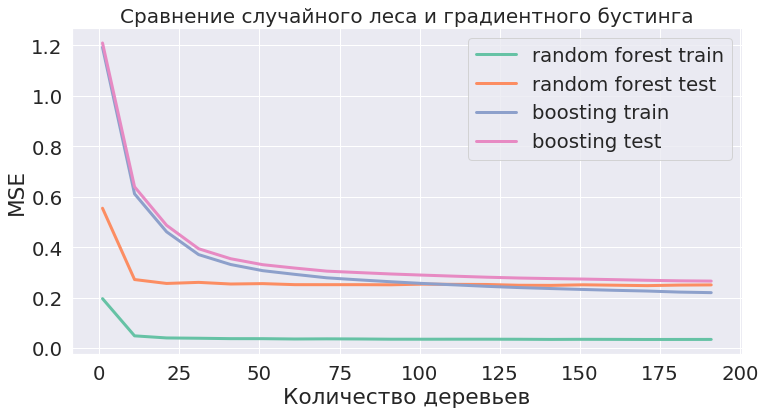

In [24]:
plot_compare_estimators(
    ['random forest', 'boosting'], n_estimators_grid, 
    [rf_mse_train, boosting_mse_train], 
    [rf_mse_test, boosting_mse_test],
    'Количество деревьев', 'MSE', 
    'Сравнение случайного леса и градиентного бустинга'
)

**Вывод.** Из графика видно, что при `n_estimators` <= 75 случайный лес показывает лучший результат, чем бустинг и на обучающей и на тестовой выборке. Однако при `n_estimators` > 75 ошибка случайного леса на тестовой выборке уже стабилизировалась, а ошибка бустинга еще продолжает убывать, в резльтате чего при всех достаточно больших значениях `n_estimators` бустинг показывает более высокий результат чем лес. Отсюда можно сделать вывод, что при работе с бустингом имеет смысл использовать большее число итераций, чтобы получить максимально высокий результат.

#### 2.2 Задача классификации

Сделаем аналогичный эксперимент с уже использованным ранее датасетом для классификации рукописных цифр.

In [25]:
print('shape:', letters_df.shape)
letters_df.head()

shape: (20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [26]:
X = letters_df.values[:, 1:]
y = letters_df.values[:, 0]

Разобьём данные на обучающую и тестовую выборки.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Обучим случайный лес для классификации и посчитаем метрику `accuracy`.

In [28]:
rf_accuracy_train = []
rf_accuracy_test = []
n_estimators_grid = range(1, 200, 25)

for n_estimators in tqdm(n_estimators_grid):
    classifier = RandomForestClassifier(n_estimators=n_estimators)
    classifier.fit(X_train, y_train)
    rf_accuracy_train.append(
        accuracy_score(classifier.predict(X_train), y_train)
    ) 
    rf_accuracy_test.append(
        accuracy_score(classifier.predict(X_test), y_test)
    )

Обучим градиентный бустинг для классификации и посчитаем метрику `accuracy`.

In [29]:
boosting_accuracy_train = []
boosting_accuracy_test = []
n_estimators_grid = range(1, 200, 25)

for n_estimators in tqdm(n_estimators_grid):
    classifier = GradientBoostingClassifier(n_estimators=n_estimators)
    classifier.fit(X_train, y_train)
    boosting_accuracy_train.append(
        accuracy_score(classifier.predict(X_train), y_train)
    ) 
    boosting_accuracy_test.append(
        accuracy_score(classifier.predict(X_test), y_test)
    )

Построим график зависимости `accuracy` от количества базовых моделей.

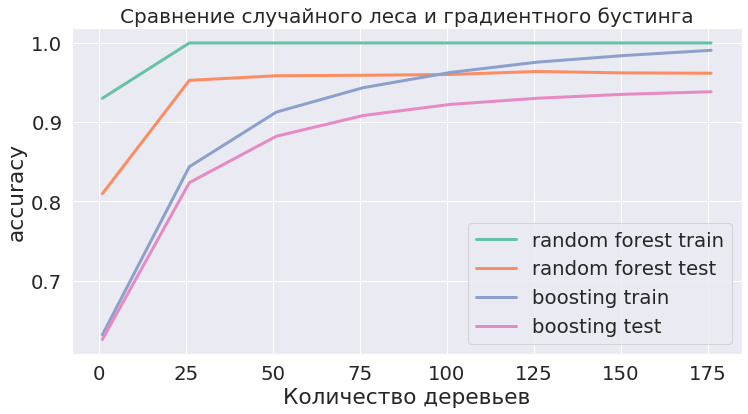

In [30]:
plot_compare_estimators(
    ['random forest', 'boosting'], n_estimators_grid, 
    [rf_accuracy_train, boosting_accuracy_train],
    [rf_accuracy_test, boosting_accuracy_test],
    'Количество деревьев', 'accuracy', 
    'Сравнение случайного леса и градиентного бустинга'
)

**Вывод.** На этом датасете при рассмотренных значениях `n_estimators` случайный лес показывает результат лучше как на обучающей, так и на тестовой выборке. Отсюда можно сделать вывод, что нет модели, которая работала бы всегда лучше других во всех задачах. Для того, чтобы получить наилучший результат, стоит рассмотреть несколько моделей.